**ML PROBLEM 5.1**

In [3]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LassoCV, Lasso
from sklearn import linear_model 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from math import *
import warnings
import os
from sklearn import preprocessing
from sklearn.model_selection import cross_validate
from sklearn.metrics import r2_score
warnings.filterwarnings("ignore")
import keras
import torch
from keras import *

In [4]:
X_train = np.load(os.path.abspath('Xtrain_Classification1.npy'))
y_train = np.load(os.path.abspath('ytrain_Classification1.npy'))
X_test  = np.load(os.path.abspath('Xtest_Classification1.npy'))

Epoch 1/60
118/118 [==============================] - 9s 67ms/step - loss: 1.3131 - f1_score: 0.4083 - sensitivity_custom: 0.1593 - balanced_accuracy_custom: 0.5161 - balanced_accuracy_enunciado: 0.3446 - val_loss: 1.0573 - val_f1_score: 0.1276 - val_sensitivity_custom: 0.1464 - val_balanced_accuracy_custom: 0.5007 - val_balanced_accuracy_enunciado: 0.3411
Epoch 2/60
118/118 [==============================] - 8s 66ms/step - loss: 0.8285 - f1_score: 0.3837 - sensitivity_custom: 0.1685 - balanced_accuracy_custom: 0.5242 - balanced_accuracy_enunciado: 0.3572 - val_loss: 0.9265 - val_f1_score: 0.1276 - val_sensitivity_custom: 0.1470 - val_balanced_accuracy_custom: 0.5015 - val_balanced_accuracy_enunciado: 0.3635
Epoch 3/60
118/118 [==============================] - 8s 65ms/step - loss: 0.7163 - f1_score: 0.4107 - sensitivity_custom: 0.1699 - balanced_accuracy_custom: 0.5256 - balanced_accuracy_enunciado: 0.3605 - val_loss: 1.0832 - val_f1_score: 0.1276 - val_sensitivity_custom: 0.1507 - va

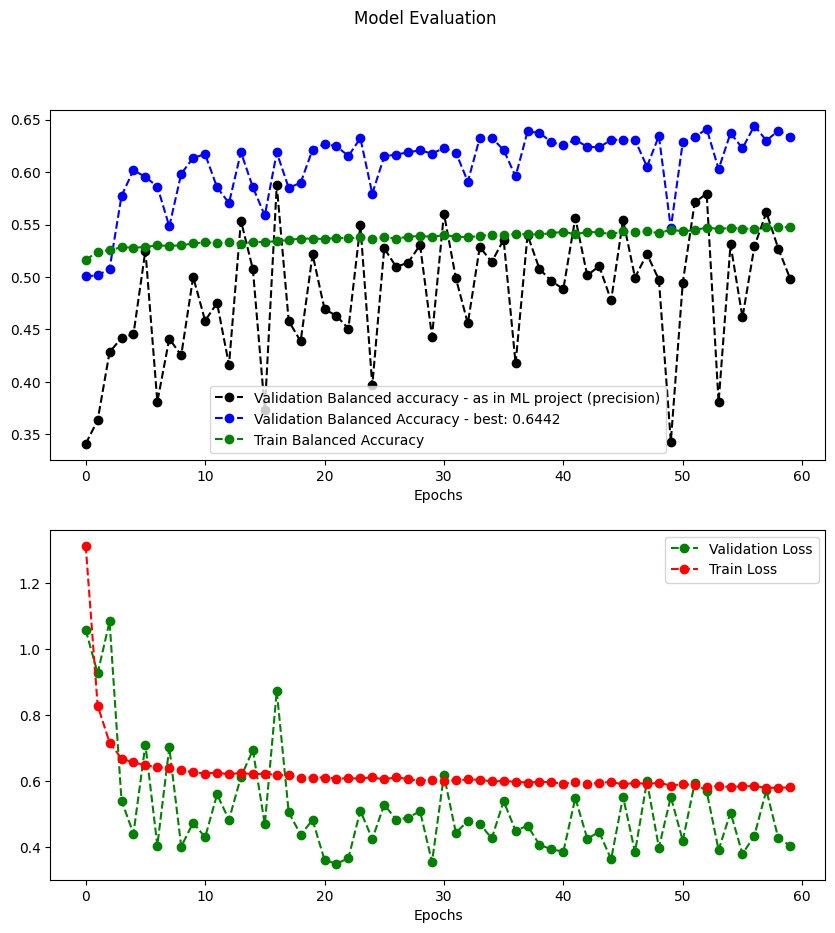

In [27]:
model_balance, model_history_balance = neural_defandTrain("adam", "categorical_crossentropy",60,128, X_train, y_train,  True, 0.2, 3)

**Neural Network**


In [21]:
def data_augmentation(x, y, augmentation_factor):
    #augmentation_factor is total nr_samples after augmentation / original nr of samples (always >1)
    data_generator = keras.preprocessing.image.ImageDataGenerator(
        rotation_range=180,
        width_shift_range=5,
        height_shift_range=5,
        brightness_range=[0.7,1.3],
        zoom_range=0.2,
        fill_mode='nearest',
        horizontal_flip=True,
        vertical_flip=True,
        )
    X_train_reshape = np.reshape(x,(x.shape[0],28,28,3))
    data_generator.fit(X_train_reshape)
    #creating arrays of new data/augmented data 
    x_augmented = np.empty([0,x.shape[1]])
    y_augmented = np.empty([0, 1])
    #generating data
    
  
    for batch_x, batch_y in data_generator.flow(X_train_reshape, y, batch_size=32, seed=500): 
        x_augmented = np.vstack([x_augmented,np.reshape(batch_x,(batch_x.shape[0],2352))])
        y_augmented = np.vstack([y_augmented, np.reshape(batch_y,(batch_y.shape[0],1))])
        if x_augmented.shape[0] > (x.shape[0])*(augmentation_factor-1): #stops when generated enougth data to satisfy the augmentation factor
            break
            
    
    x_train_aug=np.vstack([x, x_augmented])
    y_train_aug=np.vstack([np.reshape(y, (y.shape[0],1)), y_augmented])
    return x_train_aug, y_train_aug


In [12]:
from sklearn.model_selection import train_test_split

def shuffle_data(x, y):
    permutation = np.random.permutation(len(x))
    x_shuffled = x[permutation]
    y_shuffled = y[permutation]
    return x_shuffled, y_shuffled

def x_y_preprocessing(x,y, validation_size, augmentetion_ratio):
    X_train_normalizado= x/255 
    x_shuffled, y_shuffled = shuffle_data(X_train_normalizado,y)
    X_train, X_val, y_train, y_val = train_test_split(x_shuffled, y_shuffled, test_size=validation_size)
    augmented_x_train, augmented_y_train= data_augmentation(X_train,y_train, augmentetion_ratio) #dados nao balanceados mas aumentados - 2x mais dados
    X_train_sample = np.reshape(augmented_x_train,(augmented_x_train.shape[0],28,28,3))
    x_val_sample = np.reshape(X_val,(X_val.shape[0],28,28,3))
    #only used if softmax is in use
    y_train_2labels = keras.utils.to_categorical(augmented_y_train, num_classes=2)
    y_val_2labels = keras.utils.to_categorical(y_val, num_classes=2)
    
    return  X_train_sample, y_train_2labels, x_val_sample , y_val_2labels
    

    




In [14]:
#metrics

from keras import backend as k
def onehot(y_onehot):
    y = y_onehot[:,1]
    return y

def specificity_custom(y_pred_onehot, y_true_onehot):
    y_pred, y_true = onehot(y_pred_onehot), onehot(y_true_onehot)
    neg_y_true = 1 - y_true
    neg_y_pred = 1 - y_pred
    fp = k.sum(neg_y_true * y_pred)
    tn = k.sum(neg_y_true * neg_y_pred)
    return tn / (tn + fp)

def sensitivity_custom(y_pred_onehot, y_true_onehot): #sensitivity=recall
    y_pred, y_true = onehot(y_pred_onehot), onehot(y_true_onehot)
    neg_y_pred = 1 - y_pred
    fn = k.sum(neg_y_pred*y_true)
    tp = k.sum(y_true*y_pred)
    return tp / (tp + fn)

def balanced_accuracy_custom(y_pred, y_true):  
    specificity_val = specificity_custom(y_pred, y_true)
    sensitivity_val = sensitivity_custom(y_pred, y_true)
    return (specificity_val + sensitivity_val)/2
    

def precision_custom(y_pred_onehot, y_true_onehot):  
    y_pred, y_true = onehot(y_pred_onehot), onehot(y_true_onehot)
    neg_y_true = 1 - y_true
    fp = k.sum(neg_y_true * y_pred)
    tp = k.sum(y_true*y_pred)
    return tp / (tp + fp)

def balanced_accuracy_enunciado(y_pred, y_true):  
    precision_val = precision_custom(y_pred, y_true)
    recall_val = sensitivity_custom(y_pred, y_true)#sensitivity=recall
    return (precision_val + recall_val)/2


In [15]:
from sklearn.utils import class_weight
def weighted_balance(y_Data):
    class_weights = class_weight.compute_class_weight(class_weight ='balanced', classes = np.unique(y_Data) ,y=np.reshape(y_Data, (y_Data.shape[0],)))
    return dict(enumerate(class_weights))


In [16]:

def save_model (model_fitted, model_history, optimizer_string, loss_string ,epoch_nr,batch,best_balancedAccuracy ):
    
    #define names for the files
    file_name_model=f"bestbacc_{best_balancedAccuracy}  {optimizer_string}  {loss_string}  Epoch_{epoch_nr}  Batch_{batch}  Model.keras"
    #model_path=Path(r'C:\Users\alexa\OneDrive - Universidade de Lisboa\4º Ano\1º Semestre - MEEC\Aprendizagem Automática\Labs2\ML_Aaut',file_name_model)
    file_name_history=f"bestbacc_{best_balancedAccuracy}  {optimizer_string}  {loss_string}  Epoch_{epoch_nr}  Batch_{batch}  History.npy"
    #history_path=Path(r'C:\Users\alexa\OneDrive - Universidade de Lisboa\4º Ano\1º Semestre - MEEC\Aprendizagem Automática\Labs2\ML_Aaut',file_name_history)

    #save the model in a .keras file
    model_fitted.save(file_name_model)
    #save history to numpy array
    np.save(file_name_history,model_history.history)
   

In [17]:
### Neural Network
def model_def(optimizer_string, loss_string):
    model_img= keras.Sequential()
    model_img.add(layers.Conv2D(16, kernel_size=(3, 3),padding="same", activation='relu', input_shape=(28,28,3)))
    model_img.add(layers.BatchNormalization())
    model_img.add(layers.Conv2D(16, kernel_size=(3, 3),padding="same", activation='relu', input_shape=(28,28,3), kernel_regularizer='l2'))
    model_img.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model_img.add(layers.Conv2D(32, kernel_size=(3, 3),padding="same", activation='relu', kernel_regularizer='l2'))
    model_img.add(layers.BatchNormalization())
    model_img.add(layers.Conv2D(32, kernel_size=(3, 3),padding="same", activation='relu', kernel_regularizer='l2'))
    model_img.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model_img.add(layers.Conv2D(64, kernel_size=(3, 3),padding="same", activation='relu', kernel_regularizer='l2'))

    #we do not need to use a maxpooling layer after each convolution layer, but it helps reducing computacional load
    #for simple image convolution 2-4 conv layers should be enougth. The number of filters in 
    #each layer should start with 32-64 and increase with deeper layers, which enables the CNN to learn more abstract patterns dense layers

    model_img.add(layers.Flatten())
    model_img.add(layers.Dense(128, activation='relu')) #, activity_regularizer='l2',bias_regularizer='l2'
    model_img.add(layers.Dropout(.2))
    model_img.add(layers.Dense(128, activation='relu')) #activity_regularizer='l2',bias_regularizer='l2')
    model_img.add(layers.Dropout(.2))
    model_img.add(layers.Dense(128, activation='relu')) #activity_regularizer='l2',bias_regularizer='l2')

    model_img.add(layers.Dense(2, activation='softmax'))



    model_img.compile(
            optimizer = optimizer_string,
            # Optimizer: use either ADAM or SGDM
            # Loss function to minimize
            loss = loss_string,
            # List of metrics to monitor
            metrics=[keras.metrics.F1Score(), sensitivity_custom ,balanced_accuracy_custom, balanced_accuracy_enunciado  ] #keras.metrics.Precision(),keras.metrics.Recall()
        )

    return model_img



In [25]:
def plot_neuralmodel(model):
    dtf = pd.DataFrame(model.history)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10))
    fig.suptitle('Model Evaluation')

    best_bacc =round(max(dtf.iloc[:,8]),4)
    
    ax1.plot(dtf.iloc[:,9],'ko--',label='Validation Balanced accuracy - as in ML project (precision)')
    ax1.plot(dtf.iloc[:,8],'bo--',label=f'Validation Balanced Accuracy - best: {best_bacc} ')
    ax1.plot(dtf.iloc[:,3],'go--',label=f'Train Balanced Accuracy')
    #ax1.plot(dtf.iloc[:,6],'yo--',label=f'Validation F1')
    ax1.legend()
    ax1.set_xlabel('Epochs')

    ax2.plot(dtf.iloc[:,5],'go--',label=f'Validation Loss')
    ax2.plot(dtf.iloc[:,0],'ro--',label=f'Train Loss')
    ax2.legend()
    ax2.set_xlabel('Epochs')

    

    plt.show()
    return best_bacc


In [19]:

def neural_defandTrain(optimizer_string, loss_string ,epoch_nr,batch, x_all, y_all,classweight_bool, validation_size, augmentetion_ratio):

    #X_train_sample, y_train_sample, X_validation, y_validation = x_y_preprocessing(x_all, y_all) - without model.fit(validation split)
    X_train_sample, y_train_sample, X_validation, y_validation = x_y_preprocessing(x_all, y_all, validation_size, augmentetion_ratio)
    
    model = model_def(optimizer_string, loss_string)

    if classweight_bool:
        class_weights=weighted_balance(y_all) #calcular pesos de cada classe
    else:
        class_weights =None

    #callback = keras.callbacks.EarlyStopping(monitor='val_balanced_accuracy_custom', patience=5)

    model_history = model.fit(
        X_train_sample,
        y_train_sample,
        batch_size=batch,
        epochs=epoch_nr,
        validation_data=(X_validation, y_validation), # We pass some validation for monitoring validation loss and metrics at the end of each epoch
        #validation_split=0.15,
        class_weight = class_weights)
        

    best_balancedAccuracy = plot_neuralmodel(model_history)
    save_model(model, model_history, optimizer_string, loss_string ,epoch_nr,batch, best_balancedAccuracy)
    return model, model_history
